In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# read all the words
words = open('names.txt', 'r').read().splitlines()

In [3]:
len(words)

32033

In [6]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [7]:
# build the dataset

block_size = 3 # context length : how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
#     print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
#         print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [9]:
C = torch.randn((27, 2))

In [11]:
C[5]

tensor([-0.3871,  1.8674])

In [12]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-0.3871,  1.8674])

In [13]:
C[torch.tensor([5, 6, 7])]

tensor([[-0.3871,  1.8674],
        [-0.0157, -0.3189],
        [ 1.0263, -2.0378]])

In [14]:
C[X].shape

torch.Size([228146, 3, 2])

In [15]:
X[13,2]

tensor(1)

In [16]:
C[X][13, 2]

tensor([-0.3516, -0.1155])

In [17]:
C[1]

tensor([-0.3516, -0.1155])

In [10]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [18]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [21]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape

torch.Size([228146, 6])

In [23]:
len(torch.unbind(emb, 1))

3

In [24]:
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([228146, 6])

In [25]:
a = torch.arange(18)

In [26]:
a.view(2, 9)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])

In [27]:
a.view(3, 3, 2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [30]:
a.storage()

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

In [36]:
emb.view(emb.shape[0], 6)

tensor([[-0.6743, -1.7112, -0.6743, -1.7112, -0.6743, -1.7112],
        [-0.6743, -1.7112, -0.6743, -1.7112, -0.3871,  1.8674],
        [-0.6743, -1.7112, -0.3871,  1.8674,  2.6585,  0.2347],
        ...,
        [ 1.5698, -0.4588,  1.5698, -0.4588, -0.8130, -0.7326],
        [ 1.5698, -0.4588, -0.8130, -0.7326,  1.5698, -0.4588],
        [-0.8130, -0.7326,  1.5698, -0.4588, -0.7655, -0.0906]])

In [38]:
h = emb.view(emb.shape[0], 6) @ W1 + b1

In [39]:
act = torch.tanh(h)

In [40]:
act.shape

torch.Size([228146, 100])

In [41]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [42]:
logits = act @ W2 + b2

In [43]:
counts = logits.exp()

In [44]:
probs = counts/counts.sum(1, keepdims=True)

In [45]:
probs[0].sum()

tensor(1.)

In [46]:
probs.shape

torch.Size([228146, 27])

In [47]:
Y

tensor([ 5, 13, 13,  ..., 26, 24,  0])

In [49]:
loss = -probs[torch.arange(probs.shape[0]), Y].log().mean()
loss

tensor(18.8273)

In [50]:
# ----------------- # ------------------ # --------------- #

In [171]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [12]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [166]:
sum(p.nelement() for p in parameters) # total number of parameters

3481

In [15]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
print(logits.shape)
counts = logits.exp()
probs = counts/counts.sum(1, keepdims=True)
loss = -probs[torch.arange(emb.shape[0]), Y].log().mean()
loss

torch.Size([228146, 27])


tensor(19.5052)

In [16]:
print(logits, Y.shape)
F.cross_entropy(logits, Y)

tensor([[  2.0191,  -0.5013,  13.3706,  ...,  10.2469,   2.8311,   9.2402],
        [ -6.9784,   0.8382,   9.4671,  ...,   5.7656,   4.1368,  12.4966],
        [  4.1821,  -3.6009,  17.0966,  ...,   6.5224, -10.4342,  -1.5205],
        ...,
        [ -5.8335,   0.0515,   0.8027,  ..., -10.3916,  -2.5706,  -1.6157],
        [ -1.6369,  -7.4065,   8.9311,  ...,  -5.8148,  -9.0827,   0.6466],
        [  1.0493, -15.2429,  -3.2347,  ..., -12.1904,   8.7967, -14.6360]]) torch.Size([228146])


tensor(19.5052)

In [19]:
# Why cross_entropy
logits = torch.tensor([-5, 0, 3, 100])
# logits = torch.tensor([-5, 0, 3, 5]) -5 gives same probabilities
counts = logits.exp()
probs = counts/counts.sum()
probs
# while cross_entropy substracts max and calculates probabilities

tensor([0., 0., 0., nan])

In [173]:
for p in parameters:
    p.requires_grad = True

In [76]:
for _ in range(10):
    # forward pass
    emb = C[X] 
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data += -0.1 * p.grad

19.505229949951172
17.08448600769043
15.776532173156738
14.833342552185059
14.002605438232422
13.253262519836426
12.57991886138916
11.983101844787598
11.47049331665039
11.05185604095459


In [77]:
# mini-batch for faster gradient

In [79]:
torch.randint(0, X.shape[0], (32, ))

tensor([223336, 197346, 220247,  27306, 179499, 112008, 175218, 207391, 157927,
         62791,  94096, 149740, 145502, 171052,  83620,  56669, 190875,  17847,
         80554, 139505,  77398, 225745,  97626,  72771, 198486, 171476, 170395,
         57322, 226872,  28996,  11109,  68723])

In [146]:
for _ in range(100):
    
    # mini-batch construction
    indx = torch.randint(0, X.shape[0], (32,))
#     print(indx)
    # forward pass
    emb = C[X[indx]] 
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[indx])
    print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data += -0.1 * p.grad

12.151634216308594
9.988239288330078
10.178512573242188
8.861993789672852
8.114988327026367
9.486382484436035
8.582104682922363
9.174412727355957
8.842362403869629
8.330551147460938
9.479576110839844
8.948204040527344
8.963754653930664
7.032684326171875
9.357946395874023
7.642951965332031
6.882598876953125
5.745176315307617
7.059329986572266
6.313843250274658
5.705232620239258
6.585782527923584
5.2520318031311035
9.080984115600586
5.427019119262695
7.121240139007568
7.147617340087891
7.23388147354126
6.133619785308838
6.582336902618408
5.933420181274414
6.4430060386657715
5.018683910369873
7.022917747497559
6.36554479598999
5.887740135192871
4.092906951904297
5.304605960845947
4.803378582000732
5.980230808258057
4.714079856872559
5.302881240844727
6.967769145965576
5.2848358154296875
5.275982856750488
5.57643985748291
4.479170799255371
6.032659530639648
5.2018961906433105
4.308910846710205
4.095961570739746
4.827592372894287
4.967979907989502
3.805757999420166
5.90901517868042
3.770613

In [168]:
# learning rate adjustment

lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [169]:
lri = []
lossi = []

for i in range(1000):
    
    # mini-batch construction
    indx = torch.randint(0, X.shape[0], (32,))
#     print(indx)
    # forward pass
    emb = C[X[indx]] 
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[indx])
#     print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad
        
    lri.append(lre[i])
    lossi.append(loss.item())

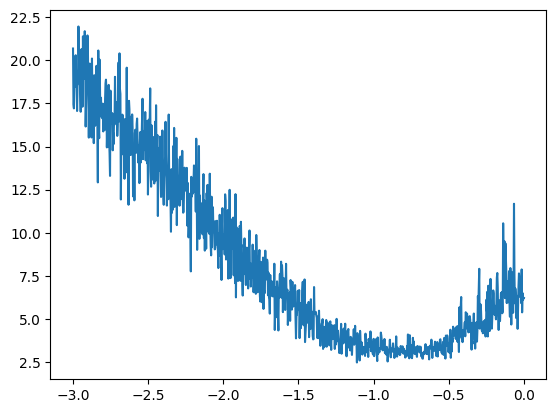

In [170]:
plt.plot(lri, lossi)

In [202]:
# lri = []
# lossi = []

for i in range(10000):
    
    # mini-batch construction
    indx = torch.randint(0, X.shape[0], (32,))
#     print(indx)
    # forward pass
    emb = C[X[indx]] 
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[indx])
#     print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
#     lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
#     lri.append(lre[i])
#     lossi.append(loss.item())

In [203]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.4039, grad_fn=<NllLossBackward0>)

In [204]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

def build_dataset(words):
    block_size = 3
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            indx = stoi[ch]
            X.append(context)
            Y.append(indx)
            context = context[1:] + [indx]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [205]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [206]:
for p in parameters:
    p.requires_grad = True

In [214]:
# lri = []
# lossi = []

for i in range(10000):
    
    # mini-batch construction
    indx = torch.randint(0, Xtr.shape[0], (32,))
#     print(indx)
    # forward pass
    emb = C[Xtr[indx]] 
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[indx])
#     print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
#     lr = lrs[i]
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad
        
#     lri.append(lre[i])
#     lossi.append(loss.item())

In [215]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.3877, grad_fn=<NllLossBackward0>)

In [216]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3895, grad_fn=<NllLossBackward0>)

In [221]:
# larger size of hidden layer
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [222]:
for p in parameters:
    p.requires_grad = True

In [236]:
# lri = []
lossi = []
stepi = []

for i in range(30000):
    
    # mini-batch construction
    indx = torch.randint(0, Xtr.shape[0], (32,))
#     print(indx)
    # forward pass
    emb = C[Xtr[indx]] 
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[indx])
#     print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
#     lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    stepi.append(i)
    lossi.append(loss.item())

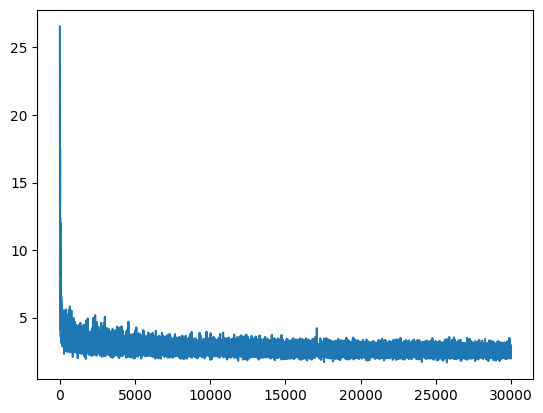

In [224]:
plt.plot(stepi, lossi)

In [237]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.2670, grad_fn=<NllLossBackward0>)

In [238]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2767, grad_fn=<NllLossBackward0>)

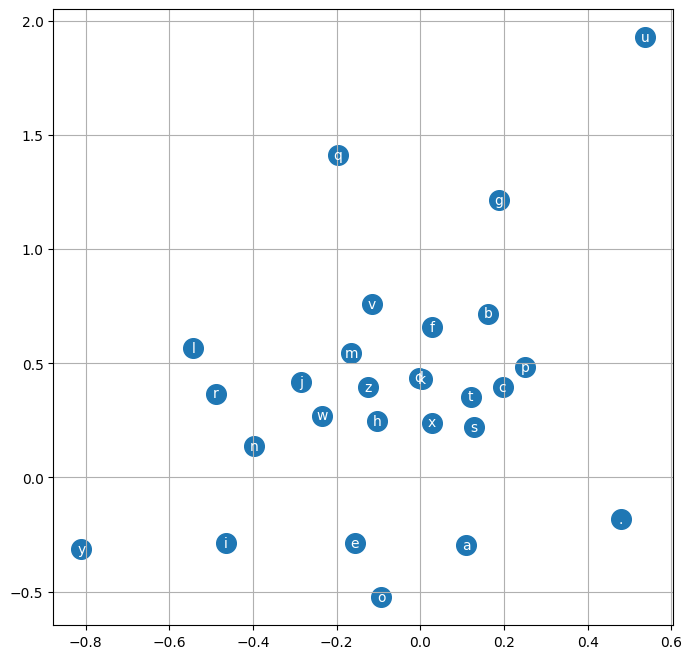

In [239]:
# visualising embeddings
plt.figure(figsize=(8, 8))
plt.scatter(C[:,0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [248]:
# larger embeddin size
# larger size of hidden layer
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [249]:
for p in parameters:
    p.requires_grad = True

In [250]:
lossi = []
stepi = []

In [258]:
# lri = []
for i in range(50000):
    
    # mini-batch construction
    indx = torch.randint(0, Xtr.shape[0], (32,))
#     print(indx)
    # forward pass
    emb = C[Xtr[indx]] 
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[indx])
#     print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
#     lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    stepi.append(i)
    lossi.append(loss.log10().item())

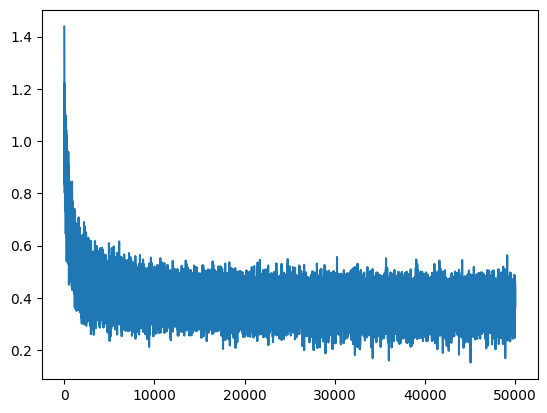

In [252]:
plt.plot(stepi, lossi)

In [259]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1640, grad_fn=<NllLossBackward0>)

In [260]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1922, grad_fn=<NllLossBackward0>)

In [264]:
# sampling from the model

g = torch.Generator().manual_seed(2147483647+10)

for _ in range(30):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        indx = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [indx]
        out.append(indx)
        if indx == 0:
            break
    
    print(''.join(itos[i] for i in out))

eria.
kayah.
see.
med.
ryah.
reverston.
rarge.
deredielin.
shy.
jen.
eden.
eson.
arleitziorona.
cayshubergiairiel.
kin.
reney.
panthuom.
usz.
geda.
jamari.
elsyria.
maston.
mahil.
salyansyn.
zakelle.
ren.
crestiveahel.
pordin.
kyloe.
bhirphilah.
